# SQL запросы

Здесь необходимо написать несколько SQL-запросов на 10 заданий. 

In [1]:
import os
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

In [ ]:
load_dotenv('db_config.env')

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('USER'),
    os.getenv('PWD'),
    os.getenv('HOST'),
    os.getenv('PORT'),
    os.getenv('DB'),
) 

engine = create_engine(connection_string) 

Проверка подключения.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
query = '''
SELECT DATE_TRUNC('month',creation_date)  AS month_date,
    SUM(views_count) AS total_views
    
FROM stackoverflow.posts
WHERE DATE_TRUNC('year',creation_date) = '2008-01-01'
GROUP BY DATE_TRUNC('month',creation_date)
ORDER BY total_views DESC
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

## Ответ:

* Данные отличаются. 
* Странно, что такая разница между июлем и остальными месяцами
* Странно, что есть информация только за 6 месяцев.
* Отличия могут быть связаны с летом и меньшей активностью летом. С июля по сентябрь просмотры растут с пиком в сентябрь, дальше падают медленнее до декабря.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

1. Создаем временную таблицу с ответами (`answers`)
2. Создаем временную таблицу с пользователями (`users_and_date`), включая в нее столбец даты создания пользователя и дату создания плюс `INTERVAL '1 month'`
3. Создаем временную таблицу (`temp_`), в которой 
    * присоединяем к таблице `answers` таблицу `users_and_date` так, чтобы напротив каждого ответа была информация о дате создания пользователя и этой же дате + месяц
    * фильтруем эту таблицу условию, что дата создания ответа (`answer_creation_date`) находилась между датой создания пользователя (`user_creation_date`) и этой же датой + месяц (`date_plus_month`)
    * из получившейся таблицы берем уникальные `user_id`, соответствующие `display_name` и считаем кол-во ответов принадлежащих каждому пользователю.
4. Из временной таблицы берем `display_name` и считаем кол-во уникальных айди пользователей по имени `COUNT(user_id) OVER (PARTITION BY display_name)`. Сортируем по `display_name`


In [7]:
query = '''
WITH answers as (SELECT id as answer_id,
                        creation_date AS answer_creation_date,
                        user_id as author_id
                FROM stackoverflow.posts
                WHERE post_type_id = 2
                ),
                
    users_and_date AS (SELECT id as user_id,
                            creation_date as user_creation_date,
                            creation_date + INTERVAL '1 month' as date_plus_month,
                            display_name
                    FROM stackoverflow.users
                    ),

    temp_ AS (SELECT DISTINCT(user_id),
                    display_name,
                    COUNT(answer_id) OVER (PARTITION BY user_id) AS answer_cnt
            FROM answers AS an JOIN users_and_date AS ud ON an.author_id = ud.user_id
            WHERE answer_creation_date BETWEEN user_creation_date AND date_plus_month
            )
SELECT display_name,
    COUNT(user_id) OVER (PARTITION BY display_name)
FROM temp_
WHERE answer_cnt > 100
ORDER BY display_name

'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
57,leppie,1
58,lomaxx,1
59,mattlant,1
60,paxdiablo,1


In [8]:
df.describe()

,count
count,62.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


<AxesSubplot:xlabel='count', ylabel='Count'>

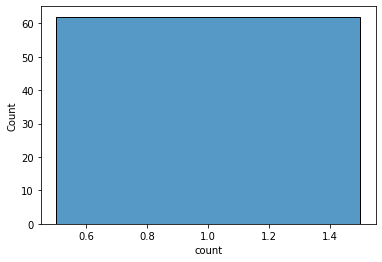

In [9]:
sns.histplot(data=df,x='count')

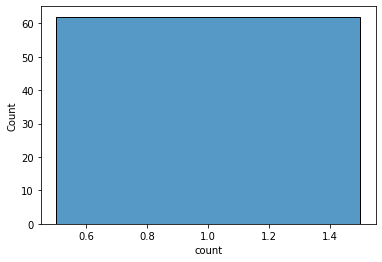

In [10]:
sns.histplot(data=df,x='count',discrete=True);

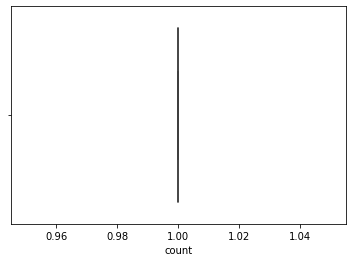

In [11]:
sns.boxplot(data=df,x='count');

Какие аномалии наблюдаются в данных? О чём они говорят?

## Ответ:

<!-- * Можно предположить, что ответы кол-вом больше 200 - это выбросы, но нужно смотреть по распределению всех данных.
* Можно предположить, что это боты. Т.к. 200 ответов / 30 дней ~ 7 ответов в день. Это много. -->
* Одному названию пользователя соответствует один user_id. Аномалий нет.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

1. Создадим временную таблицу с пользователями, зарегистрировшимися в сентябре 2008 года
2. Создадим временную таблицу с постами созданными в декабре 2008 года
3. Объединим эти таблицы в одну с помощью INNER JOIN, чтобы отфильтровать пользователей зарегистрированных в сент. 2008 и сделавших хотя бы 1 пост в дек. 2008
4. Отфильтруем пользователей в таблице `stackoverflow.posts`, чтобы в нее попали только пользователи из 3 таблицы и выведем месяц и кол-во постов.

In [12]:
query = '''
WITH users_sept_2008 AS (SELECT id
                        FROM stackoverflow.users
                        WHERE DATE_TRUNC('month',creation_date) = '2008-09-01'
                        ),
    posts_dec_2008 AS (SELECT *
                    FROM stackoverflow.posts
                    WHERE DATE_TRUNC('month',creation_date) = '2008-12-01'
                    ),

    users_ AS (SELECT DISTINCT(user_id)
                FROM posts_dec_2008 as pd INNER JOIN users_sept_2008 as us ON pd.user_id = us.id
                )

SELECT DATE_TRUNC('month',creation_date) AS date_month,
        COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id FROM users_)
GROUP BY DATE_TRUNC('month',creation_date)
ORDER BY date_month DESC

'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,date_month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

## Ответ:

* Не должно быть постов в августе 2008 года, т.е. раньше, чем зарегистрировались пользователи.
* Проблема, скорее всего, в дате создания поста `stackoverflow.posts.creation_date`. Техническая проблема?

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [13]:
query = '''
SELECT user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) as cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

<!-- 1. Создадим временную таблицу с постами, опубликованными в августе.
2. Создадим временную таблицу с айди пользователей, которые есть в таблице выше и имеют больше 120 постов.
3. Создадим временную таблицу с постами 
    * за август 2008 года, 
    * отфильтруем по айди пользователей по таблице 2,
    * возьмем айди пользователя, день месяца и кол-во постов в этот день -->

In [14]:
query = '''
WITH posts_aug AS (SELECT DISTINCT(user_id),
                            COUNT(id) OVER (PARTITION BY user_id) AS posts_count
                    FROM stackoverflow.posts
                    WHERE DATE_TRUNC('month',creation_date) = '2008-08-01'
                    ),
                    
    users_ AS (SELECT user_id
                FROM posts_aug
                WHERE posts_count > 120
                ),

    temp_ AS (SELECT --*,
                    user_id,
                    EXTRACT(DAY from creation_date) AS aug_day,
                    COUNT(ID) OVER (PARTITION BY user_id, EXTRACT(DAY from creation_date)) AS posts_count_by_day,
                    ROW_NUMBER() OVER (PARTITION BY user_id, EXTRACT(DAY from creation_date)) AS row_n
                FROM stackoverflow.posts
                WHERE user_id IN (SELECT user_id FROM users_)
                    AND DATE_TRUNC('month',creation_date) = '2008-08-01'
                )
SELECT user_id,
    AVG(posts_count_by_day) as avg_posts
FROM temp_       
WHERE row_n = 1
GROUP BY user_id
ORDER BY avg_posts
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,user_id,avg_posts
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [15]:
query = '''
WITH temp_ AS (SELECT user_id,
                        COUNT(DISTINCT(DATE_TRUNC('day',creation_date)))
                FROM stackoverflow.posts
                WHERE DATE_TRUNC('day',creation_date) BETWEEN '2008-12-1' AND '2008-12-7'
                GROUP BY user_id
                )
SELECT ROUND(AVG(count))
FROM temp_

'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,round
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

# Ответ:

* С 1 по 7 декабря 2008 года пользователи в среднем проявляли активность в 2х днях.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

В качестве оконной функции используем `LAG()` на 2 смещения по дате создания поста `creation_date`, которую одновременно переводим в названия месяца строкой. А само окно определяем по `user_id` и сортируем по `creation_date`.

Так получается мы берем название месяца из даты предпоследнего поста.

In [16]:
query = '''
SELECT user_id,
    creation_date,
    LAG(TO_CHAR(creation_date,'Month'),2) OVER (PARTITION BY user_id ORDER BY creation_date) as second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


In [17]:
df[df['user_id'] == 2]

,user_id,creation_date,second_last_month
70,2,2008-08-01 04:59:34,None
71,2,2008-08-01 05:09:56,None
72,2,2008-08-04 05:51:57,August
73,2,2008-08-21 20:53:51,August
74,2,2008-10-13 23:46:09,August
75,2,2008-12-15 03:59:56,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [18]:
query = '''
WITH first_post_date AS (SELECT user_id,
                                MIN(DATE_TRUNC('month',creation_date)) as cohort_month
                        FROM stackoverflow.posts
                        GROUP BY user_id
                        ),
    profile AS (SELECT *,
                    COUNT(*) OVER (PARTITION BY cohort_month) as cohort_users_cnt
                FROM first_post_date
                ),
    sessions AS (SELECT user_id,
                    DATE_TRUNC('month',creation_date) as session_month
                FROM stackoverflow.posts
                GROUP BY 1, 2
                )
SELECT p.cohort_month,
    s.session_month,
    COUNT(p.user_id) AS users_cnt,
    cohort_users_cnt,
    ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,2,4
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,cohort_month,session_month,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

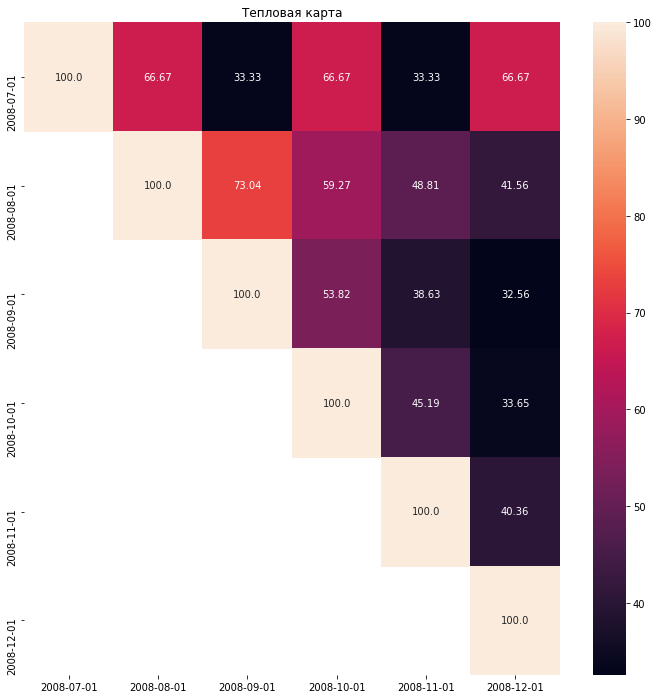

In [19]:
retention = df.pivot('cohort_month', 'session_month', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(12, 12)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

## Ответ:
* Июльская когорта состоит из 3х пользователей, поэтому такие показатели.
* Каждая последующая когорта имеет retention rate ниже предыдущей.


# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

1. Формируем временную таблицу, в которой считаем кол-во постов в месяц за период с сентября по декабрь 2008 года включительно.
2. Чтобы вычислить процент изменений кол-ва постов:
    * Из количества постов `posts_count` вычитаем предыдущее значение кол-ва постов `LAG(posts_count) OVER ()` и делим тоже на предыдущее кол-во постов `LAG(posts_count) OVER ()`
    * При этом делимое переводим в тип `numeric` с помощью `CAST( *** as numeric)`
    * Получившееся значение умножаем на `100` и округляем до сотых `ROUND( *** ,2)`

In [20]:
query = '''
WITH posts_by_month AS (SELECT EXTRACT(month FROM creation_date) as creation_month,
                            COUNT(id) as posts_count
                        FROM stackoverflow.posts
                        WHERE DATE_TRUNC('month',creation_date) BETWEEN '2008-09-01' AND '2008-12-01'
                        GROUP BY creation_month
                        )

SELECT *,
    ROUND(
        CAST((posts_count - LAG(posts_count) OVER (ORDER BY creation_month)) as numeric)/LAG(posts_count) OVER (ORDER BY creation_month) * 100
        ,2)  as percentage
FROM posts_by_month

'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

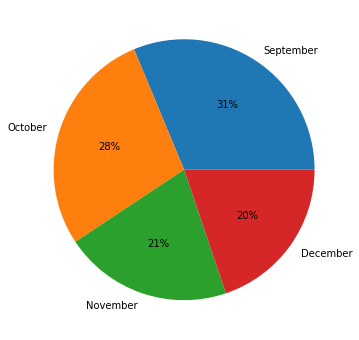

In [21]:
# постройте круговую диаграмму с количеством постов по месяцам
plt.figure(figsize=(6,6))
plt.pie(x=df['posts_count'],labels=['September','October','November','December'],
        autopct='%.0f%%')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [22]:
query = '''
WITH user_ AS (SELECT user_id
            FROM stackoverflow.posts
            GROUP BY user_id
            ORDER BY COUNT(id) DESC
            LIMIT 1
            )

SELECT DISTINCT(EXTRACT(week FROM creation_date)),
        MAX(creation_date) OVER (PARTITION BY EXTRACT(week FROM creation_date))
FROM stackoverflow.posts
WHERE DATE_TRUNC('month',creation_date) = '2008-10-01'
    AND user_id = (SELECT user_id FROM user_)
'''

df = pd.read_sql_query(query, con=engine) 
display(df)

,date_part,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
